In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# setup
TRAIN_PATH = "../input/house-prices-advanced-regression-techniques/train.csv"
TEST_PATH = "../input/house-prices-advanced-regression-techniques/test.csv"
SUBMISSION_PATH = "../input/house-prices-advanced-regression-techniques/sample_submission.csv"

OUTPUT_PATH = "../output/kaggle/working/submission.csv"

In [3]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
sample_submission_df = pd.read_csv(SUBMISSION_PATH)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
sample_submission_df.head(5)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


### Approach
1. First, lets create a basic LinearRegression Model using few features like Bedroom, Bathroom and SqFt
2. We will take that neg RMSE as the baseline evaluation metric
3. Then we will perform some feature engineering
4. We will use more complex models
5. Perform model hyper parameter tuning

In [6]:
train_df[["FullBath"]].value_counts()

FullBath
2           768
1           650
3            33
0             9
dtype: int64

In [7]:
train_df[["LotArea"]].value_counts()

LotArea
7200       25
9600       24
6000       17
9000       14
10800      14
           ..
8930        1
8935        1
8944        1
8960        1
215245      1
Length: 1073, dtype: int64

<AxesSubplot:ylabel='Frequency'>

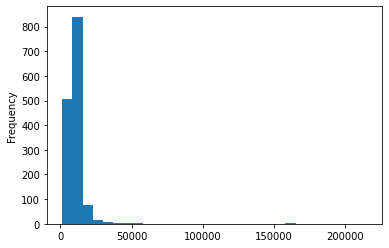

In [8]:
train_df["LotArea"].plot.hist(bins = 30)

<AxesSubplot:ylabel='Frequency'>

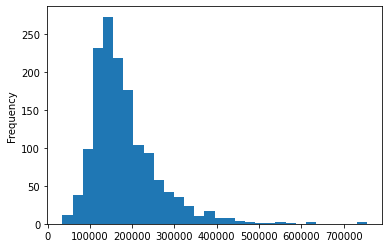

In [9]:
train_df["SalePrice"].plot.hist(bins = 30)

In [10]:
# perform minmax scaler
def perform_minmaxscaler(df, col):
    min_value = df[col].min()
    max_value = df[col].max()
    df[col] = (df[col] - min_value) / (max_value - min_value)
    return df

# perform cross validation
from sklearn.model_selection import cross_val_score
def perform_cross_validation(model, features, target, train):
    X = train[features]
    Y = train[target]
    scores = cross_val_score(model, X, Y, cv=10, scoring = 'neg_root_mean_squared_error')
    mean_score = np.mean(scores)
    return mean_score
    

In [11]:
train_df[["BedroomAbvGr"]].value_counts()

BedroomAbvGr
3               804
2               358
4               213
1                50
5                21
6                 7
0                 6
8                 1
dtype: int64

In [12]:
initial_features = ["TotRmsAbvGrd", "LotArea", "FullBath"]
target = "SalePrice"
for col in initial_features:
    train_df = perform_minmaxscaler(train_df, col)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

model = LinearRegression()
#model.fit(train_df[initial_features], train_df[target])
score = perform_cross_validation(model, initial_features, target, train_df)
print(score)

-61274.52565300374


In [14]:
def model_training(train_df, features, target):
    model = RandomForestRegressor()
    X = train_df[features]
    Y = train_df[target]
    model.fit(X, Y)
    return model
    
def generate_predictions(model, test_df, features):
    for col in initial_features:
        test_df = perform_minmaxscaler(test_df, col)
    predictions = model.predict(test_df[features])
    return predictions

In [15]:
model = model_training(train_df, initial_features, target)
predictions = generate_predictions(model, test_df, initial_features)

In [16]:
# ids = test_df["Id"]
# submission = pd.DataFrame(
#     {
#         "Id": ids,
#         "SalePrice": predictions
#     }
# )

# submission.to_csv("submission.csv", index=False)

Done with the baseline model with few columns. Best score of 0.33691.

Perform more feature engineering and advanced tasks next.

In [17]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
sample_submission_df = pd.read_csv(SUBMISSION_PATH)

corr_df = train_df.corr().loc[:, ["SalePrice"]]
cols_of_interest = corr_df[np.abs(corr_df["SalePrice"]) > 0.2].index
# since there are lot of features, we will only focus on those features that have correlation > 0.3

In [18]:
cols_of_interest

Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'SalePrice'],
      dtype='object')

In [19]:
train_df = train_df[cols_of_interest]

In [20]:
train_df

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
0,65.0,8450,7,2003,2003,196.0,706,150,856,856,...,2,1,8,0,2003.0,2,548,0,61,208500
1,80.0,9600,6,1976,1976,0.0,978,284,1262,1262,...,2,0,6,1,1976.0,2,460,298,0,181500
2,68.0,11250,7,2001,2002,162.0,486,434,920,920,...,2,1,6,1,2001.0,2,608,0,42,223500
3,60.0,9550,7,1915,1970,0.0,216,540,756,961,...,1,0,7,1,1998.0,3,642,0,35,140000
4,84.0,14260,8,2000,2000,350.0,655,490,1145,1145,...,2,1,9,1,2000.0,3,836,192,84,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,6,1999,2000,0.0,0,953,953,953,...,2,1,7,1,1999.0,2,460,0,40,175000
1456,85.0,13175,6,1978,1988,119.0,790,589,1542,2073,...,2,0,7,2,1978.0,2,500,349,0,210000
1457,66.0,9042,7,1941,2006,0.0,275,877,1152,1188,...,2,0,9,2,1941.0,1,252,0,60,266500
1458,68.0,9717,5,1950,1996,0.0,49,0,1078,1078,...,1,0,5,0,1950.0,1,240,366,0,142125


<AxesSubplot:ylabel='Frequency'>

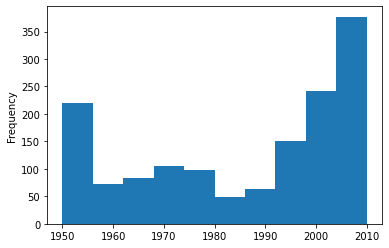

In [21]:
train_df["YearRemodAdd"].plot.hist()

In [22]:
train_df[train_df["WoodDeckSF"] == 0].shape # removing the WoodDeckSF since 761 records have value = 0

(761, 23)

In [23]:
train_df[train_df["OpenPorchSF"] == 0].shape # removing the OpenPorchSF since 761 records have value = 0

(656, 23)

In [24]:
train_df.loc[:, ["GarageArea", "GarageCars"]].corr()
# Looks like GarageArea and GarageCars are highly correlated 
# so lets use only GarageCars and drop the GarageArea column


,GarageArea,GarageCars
GarageArea,1.000000,0.882475
GarageCars,0.882475,1.000000


In [25]:
train_df.loc[:, ["BsmtFinSF1", "BsmtUnfSF", "TotalBsmtSF"]].head(4)
# lets just use the TotalBsmtSF as its a summation of Finished + Unfinished sq ft
# need to drop BsmtFinSF1 and BsmtUnfSF

,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF
0,706,150,856
1,978,284,1262
2,486,434,920
3,216,540,756


In [26]:
# drop MasVnrArea, YearBuilt, LotFrontage and GarageYrBlt
train_final_df = train_df.copy()
# train_df.drop(columns = ["1stFlrSF", "2ndFlrSF", "TotalBsmtSF"])
# dropping TotalBsmtSF since its value is same as the 1stFlrSF
cols_to_drop = ["BsmtFinSF1", "BsmtUnfSF", "GarageArea", "OpenPorchSF", "WoodDeckSF", "MasVnrArea", "GarageYrBlt", "LotFrontage", "YearBuilt", "1stFlrSF", "2ndFlrSF", "TotalBsmtSF"]
train_final_df = train_final_df.drop(columns = cols_to_drop)


In [27]:
train_final_df.head(5)

,LotArea,OverallQual,YearRemodAdd,GrLivArea,BsmtFullBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,SalePrice
0,8450,7,2003,1710,1,2,1,8,0,2,208500
1,9600,6,1976,1262,0,2,0,6,1,2,181500
2,11250,7,2002,1786,1,2,1,6,1,2,223500
3,9550,7,1970,1717,1,1,0,7,1,3,140000
4,14260,8,2000,2198,1,2,1,9,1,3,250000


<AxesSubplot:ylabel='Frequency'>

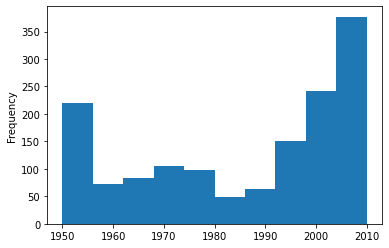

In [28]:
train_final_df["YearRemodAdd"].plot.hist()

In [29]:
# map the YearRemodAdd to numerical values
# since more recent the remod year better it is, we will map the histogram bins and assign them numbers
def map_year_remod(year):
    if year >= 1950 and year < 1960:
        return 1
    elif year >= 1960 and year < 1970:
        return 2
    elif year >= 1970 and year < 1980:
        return 3
    elif year >= 1980 and year < 1990:
        return 4
    elif year >= 1990 and year < 2000:
        return 5
    else:
        return 6

In [30]:
train_final_df["remod_year_mapped"] = train_final_df['YearRemodAdd'].apply(map_year_remod)
train_final_df = train_final_df.drop(columns = ["YearRemodAdd"])

In [31]:
train_final_df.head(5)

,LotArea,OverallQual,GrLivArea,BsmtFullBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,SalePrice,remod_year_mapped
0,8450,7,1710,1,2,1,8,0,2,208500,6
1,9600,6,1262,0,2,0,6,1,2,181500,3
2,11250,7,1786,1,2,1,6,1,2,223500,6
3,9550,7,1717,1,1,0,7,1,3,140000,3
4,14260,8,2198,1,2,1,9,1,3,250000,6


In [32]:
features = ["LotArea", "OverallQual", "GrLivArea", "BsmtFullBath", "FullBath", "HalfBath", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "remod_year_mapped"]
target = "SalePrice"

models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
for m in models:
    rmse = perform_cross_validation(m, features, target, train_final_df)
    print(rmse)

-37623.66474782881
-42782.952538204896
-32712.667614211423


In [33]:
# Looks like RandomForestRegressor has the lowest error.
# Let us try to fit and make the predictions
test_df["remod_year_mapped"] = test_df['YearRemodAdd'].apply(map_year_remod)
test_df["BsmtFullBath"] = test_df["BsmtFullBath"].fillna(test_df["BsmtFullBath"].mode()[0])
test_df["GarageCars"] = test_df["GarageCars"].fillna(test_df["GarageCars"].mode()[0])

model = RandomForestRegressor(random_state = 1)
model.fit(train_final_df[features], train_final_df[target])
predictions = model.predict(test_df[features])

In [34]:
# ids = test_df["Id"]
# submission = pd.DataFrame(
#     {
#         "Id": ids,
#         "SalePrice": predictions
#     }
# )

# submission.to_csv("submission.csv", index=False)

In [35]:
# # score of 0.16504 (not too shabby!)
# # lets try hyper parameter optimization using GridSearchCV
# from sklearn.model_selection import GridSearchCV

# rfRegressor = \
# {
#     "name": "RandomForestRegressor",
#     "estimator": RandomForestRegressor(random_state=1),
#     "hyperparameters":
#         {
#             "n_estimators": [100],
#             "criterion": ["mae"],
#             "max_depth": [10],
#             #"max_features": ["log2", "sqrt"],
#             "min_samples_leaf": [3, 6, 9, 12],
#             "min_samples_split": [3, 6, 9, 12]

#         }
# }
# grid = GridSearchCV(rfRegressor["estimator"],
#                             param_grid=rfRegressor["hyperparameters"],
#                             cv=10)
# grid.fit(train_final_df[features],train_final_df[target])

# print("Best Score: {}".format(grid.best_score_))
# print("Best Parameters: {}\n".format(grid.best_params_))

# final_model = grid.best_estimator_

In [36]:
train_final_df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   LotArea            1460 non-null   int64
 1   OverallQual        1460 non-null   int64
 2   GrLivArea          1460 non-null   int64
 3   BsmtFullBath       1460 non-null   int64
 4   FullBath           1460 non-null   int64
 5   HalfBath           1460 non-null   int64
 6   TotRmsAbvGrd       1460 non-null   int64
 7   Fireplaces         1460 non-null   int64
 8   GarageCars         1460 non-null   int64
 9   remod_year_mapped  1460 non-null   int64
dtypes: int64(10)
memory usage: 114.2 KB


In [37]:
test_df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LotArea            1459 non-null   int64  
 1   OverallQual        1459 non-null   int64  
 2   GrLivArea          1459 non-null   int64  
 3   BsmtFullBath       1459 non-null   float64
 4   FullBath           1459 non-null   int64  
 5   HalfBath           1459 non-null   int64  
 6   TotRmsAbvGrd       1459 non-null   int64  
 7   Fireplaces         1459 non-null   int64  
 8   GarageCars         1459 non-null   float64
 9   remod_year_mapped  1459 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 114.1 KB


In [38]:
test_df["BsmtFullBath"] = test_df["BsmtFullBath"].astype(int)
test_df["GarageCars"] = test_df["GarageCars"].astype(int)

In [39]:
# create final submission file

final_model = RandomForestRegressor(criterion='mae', max_depth=10, min_samples_leaf=3,
                      min_samples_split=3, random_state=1)
model.fit(train_final_df[features], train_final_df[target])
predictions = model.predict(test_df[features])

ids = test_df["Id"]
submission = pd.DataFrame(
    {
        "Id": ids,
        "SalePrice": predictions
    }
)

submission.to_csv("submission.csv", index=False)

In [40]:
test_df[features].head(4)

,LotArea,OverallQual,GrLivArea,BsmtFullBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,remod_year_mapped
0,11622,5,896,0,1,0,5,0,1,2
1,14267,6,1329,0,1,1,6,0,1,1
2,13830,5,1629,0,2,1,6,1,2,5
3,9978,6,1604,0,2,1,7,1,2,5
